In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 277 ms (started: 2022-09-12 13:57:31 -07:00)


Images of Brendan Frey’s face at a (20 x 28 resolution), as far as I know originating from a page belonging to [Saul Roweis](https://cs.nyu.edu/~roweis/data.html). The file reading code below is based on a [blog post by Elvis Dohmato](https://dohmatob.github.io/research/2016/10/22/VAE.html).

In [2]:
from io import BytesIO

import requests
import scipy.io

req = requests.get(
    "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat",
    timeout=10,
)
data = scipy.io.loadmat(BytesIO(req.content), squeeze_me=True, struct_as_record=False)

time: 1.38 s (started: 2022-09-12 13:57:31 -07:00)


In [3]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: LNX86, Created on: Mon Nov 13 18:11:48 2000',
 '__version__': '1.0',
 '__globals__': [],
 'ff': array([[ 81,  85,  87, ...,  80,  73,  58],
        [136, 138, 139, ...,  84,  86,  89],
        [167, 165, 166, ..., 155, 131, 110],
        ...,
        [152, 167, 172, ..., 111, 135, 166],
        [158, 178, 177, ..., 186, 167, 177],
        [164, 184, 183, ..., 182, 177, 184]], dtype=uint8)}

time: 8.79 ms (started: 2022-09-12 13:57:33 -07:00)


In [4]:
data = data["ff"]
data, data.shape

(array([[ 81,  85,  87, ...,  80,  73,  58],
        [136, 138, 139, ...,  84,  86,  89],
        [167, 165, 166, ..., 155, 131, 110],
        ...,
        [152, 167, 172, ..., 111, 135, 166],
        [158, 178, 177, ..., 186, 167, 177],
        [164, 184, 183, ..., 182, 177, 184]], dtype=uint8),
 (560, 1965))

time: 4.8 ms (started: 2022-09-12 13:57:33 -07:00)


Please note that this data set is stored by column, i.e. the first image is in the first *column* not the first *row*.

## View a face

In [5]:
import math

import matplotlib.pyplot as plt


def show_frey(frey, image):
    if not 0 <= image < 1964:
        raise ValueError(f"image should be a value in [0, 1964]")
    nx = 20
    ny = 28
    sizex = 1
    sizey = sizex * (ny / nx)
    plt.figure(figsize=(sizex, sizey))
    plt.axis("off")
    plt.imshow(
        frey[:, image].reshape((ny, nx)),
        cmap=plt.cm.gray,
        interpolation="nearest",
        vmin=0,
        vmax=255,
    )

time: 491 ms (started: 2022-09-12 13:57:33 -07:00)


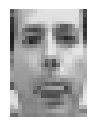

time: 49.1 ms (started: 2022-09-12 13:57:33 -07:00)


In [6]:
show_frey(data, 0)

## Pipeline

Transpose the data so the images are in the rows, not columns before proceeding:

In [7]:
data = data.T

time: 762 µs (started: 2022-09-12 13:57:33 -07:00)


In [8]:
from drnb.dataset import create_data_pipeline

data_pipe = create_data_pipeline(
    data_export=["csv", "npy"],
    target_export=["csv", "pkl"],
    neighbors=dict(
        n_neighbors=[15, 50, 150],
        method="exact",
        metric=["euclidean"],
        file_types=["csv", "npy"],
    ),
    triplets=dict(
        n_triplets_per_point=5,
        seed=1337,
        file_types=["csv", "npy"],
    ),
    verbose=True,
)

[13:57:41] INFO     Requesting one extra neighbor to account for self-neighbor                       ]8;id=784924;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=758468;file:///home/james/dev/drnb/src/drnb/dataset.py#318\318]8;;\

time: 7.31 s (started: 2022-09-12 13:57:33 -07:00)


In [9]:
data_result = data_pipe.run("frey", data=data, verbose=True)

           INFO     initial data shape: (1965, 560)                                                   ]8;id=159879;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=880357;file:///home/james/dev/drnb/src/drnb/dataset.py#45\45]8;;\

           INFO     Removing rows with NAs                                                            ]8;id=961208;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=999243;file:///home/james/dev/drnb/src/drnb/dataset.py#85\85]8;;\

           INFO     data shape after filtering NAs: (1965, 560)                                       ]8;id=996723;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=497836;file:///home/james/dev/drnb/src/drnb/dataset.py#94\94]8;;\

           INFO     Keeping all columns                                                            ]8;id=380687;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=707118;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     data shape after filtering columns: (1965, 560)                                   ]8;id=549389;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=325522;file:///home/james/dev/drnb/src/drnb/dataset.py#99\99]8;;\

           INFO     No scaling                                                                     ]8;id=754865;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=107388;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                     ]8;id=781761;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=256241;file:///home/james/dev/drnb/src/drnb/dataset.py#104\104]8;;\

           INFO     Writing data for frey                                                            ]8;id=932391;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=81522;file:///home/james/dev/drnb/src/drnb/dataset.py#162\162]8;;\

[13:57:42] INFO     Calculating nearest neighbors                                                    ]8;id=732462;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=328308;file:///home/james/dev/drnb/src/drnb/dataset.py#173\173]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=454099;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=230033;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#71\71]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=181145;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=423961;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=947567;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=300290;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=932904;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=293490;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=705933;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=512898;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

[13:57:49] INFO     Calculating triplets                                                             ]8;id=53646;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=928457;file:///home/james/dev/drnb/src/drnb/dataset.py#209\209]8;;\

           INFO     Writing csv format to triplets/frey.5.1337.idx.csv                              ]8;id=506356;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=824019;file:///home/james/dev/drnb/src/drnb/io/__init__.py#207\207]8;;\

           INFO     Writing csv format to triplets/frey.5.1337.l2.csv                               ]8;id=762816;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=583267;file:///home/james/dev/drnb/src/drnb/io/__init__.py#207\207]8;;\

           INFO     Writing numpy format to triplets/frey.5.1337.idx.npy                            ]8;id=121529;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=709594;file:///home/james/dev/drnb/src/drnb/io/__init__.py#230\230]8;;\

           INFO     Writing numpy format to triplets/frey.5.1337.l2.npy                             ]8;id=830487;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=727806;file:///home/james/dev/drnb/src/drnb/io/__init__.py#230\230]8;;\

           INFO     Writing pipeline result for frey                                                  ]8;id=745955;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=395679;file:///home/james/dev/drnb/src/drnb/dataset.py#79\79]8;;\

time: 8.72 s (started: 2022-09-12 13:57:41 -07:00)
